In [130]:
from typing import List
import os
import abc
import dataclasses
from dataclasses import dataclass
from collections import defaultdict
import scipy.stats
import numpy as np
import pandas as pd
import PIL
import functools
from PIL import Image
import matplotlib.pyplot as plt
import time
import datetime

## Utilities

In [2]:
def load_grayscale_image_as_numpy_array(path):
    return np.asarray(Image.open(path).convert(mode='L')).astype(np.float32)


def load_binary_image_as_numpy_array(path):
    image = load_grayscale_image_as_numpy_array(path)
    return 255.0 * (image > 127.5)


def show_image(image, figsize=(12, 8), cmap='gray'):
    plt.figure(figsize=figsize)
    plt.tick_params(labelbottom=False, labelleft=False)
    plt.imshow(image, cmap=cmap)

In [3]:
def pad_ising_model(input_image):
    return np.pad(input_image, pad_width=1, mode='symmetric')


def unpad_ising_model(input_image):
    return input_image[1:-1, 1:-1]


def convert_image_to_ising_model(input_image):
    return pad_ising_model(input_image / 127.5 - 1.0)


def convert_ising_model_to_image(input_image):
    return unpad_ising_model((input_image + 1.0) * 127.5)

## Test data

In [77]:
BINARY_IMAGES_PATH = "binary_images/300x300_easy_noise10"
GRAYSCALE_IMAGES_PATH = "grayscale_images/size800_noise10_independent_distance100"

In [78]:
BINARY_IMAGE_OBSEVATION = load_binary_image_as_numpy_array(
    path=os.path.join(BINARY_IMAGES_PATH, "image_0_observation.png")
)
BINARY_IMAGE_GROUND_TRUTH = load_binary_image_as_numpy_array(
    path=os.path.join(BINARY_IMAGES_PATH, "image_0_ground_truth.png")
)
GRAYSCALE_IMAGE_OBSERVATION = load_grayscale_image_as_numpy_array(
    path=os.path.join(GRAYSCALE_IMAGES_PATH, "image_1_observation.png")
)
GRAYSCALE_IMAGE_GROUND_TRUTH = load_grayscale_image_as_numpy_array(
    path=os.path.join(GRAYSCALE_IMAGES_PATH, "image_1_ground_truth.png")
)

## Interface for noise reducers

In [6]:
@dataclass
class NoiseReducerStatistics(object):
    evaluation_losses: List[float] = dataclasses.field(default_factory=list)
    computation_times: List[float] = dataclasses.field(default_factory=list)


@dataclass
class NoiseReducerResult(object):
    original_image: np.ndarray
    obsevation: np.ndarray
    reduced_image: np.ndarray
    statistics: NoiseReducerStatistics

In [116]:
class SupervisedNoiseReducer(object):
    def __init__(self, iterations_count, iterations_per_evaluation):
        self._iterations_count = iterations_count
        self._iterations_per_evaluation = iterations_per_evaluation
        self._average_statistics = NoiseReducerStatistics()

    @property
    def average_statistics(self):
        return self._average_statistics

    def _preprocess(self, observation):
        pass

    @abc.abstractmethod
    def _sampler_step(self, observation, current_state):
        pass
    
    def _evaluate_noise_reduction(self, original_image, reduced_image):
        return np.mean(np.abs(original_image - reduced_image))
    
    def _update_average_statistics(self, image_statistics):
        evaluation_loss = image_statistics.evaluation_losses[-1]
        self.average_statistics.evaluation_losses.append(evaluation_loss)
        average_computation_time = np.mean(image_statistics.computation_times)
        self.average_statistics.computation_times.append(average_computation_time)        

    def reduce_noise(self, original_image, observation):
        initial_state = convert_image_to_ising_model(observation)
        current_state = initial_state.copy()
        statistics = NoiseReducerStatistics()
        self._preprocess(initial_state)
        for iteration in range(1, self._iterations_count + 1):
            start_time = time.time()          
            self._sampler_step(initial_state, current_state)
            statistics.computation_times.append(1000 * (time.time() - start_time))
            if iteration % self._iterations_per_evaluation == 0:
                statistics.evaluation_losses.append(self._evaluate_noise_reduction(
                    original_image=original_image,                    
                    reduced_image=convert_ising_model_to_image(current_state),
                ))
        self._update_average_statistics(statistics)
        return NoiseReducerResult(
            original_image=original_image,
            obsevation=observation,
            reduced_image=convert_ising_model_to_image(current_state),
            statistics=statistics,
        )

## BinaryGibbsNoiseReducer

In [199]:
class BinaryGibbsNoiseReducer(SupervisedNoiseReducer):
    def __init__(self, noise_level_prior, observation_strength, coupling_strength, **kwargs):
        self._noise_level_prior = noise_level_prior
        self._observation_strength = observation_strength
        self._coupling_strength = coupling_strength
        super(BinaryGibbsNoiseReducer, self).__init__(**kwargs)

    def _observation_potential(self, observation_pbty):
        return self._observation_strength * np.log(observation_pbty)

    @functools.lru_cache(maxsize=None)
    def _positive_observation_potential(self, observation_value):
        if observation_value >= 0.0:
            return self._observation_potential(1.0 - self._noise_level_prior)
        return self._observation_potential(self._noise_level_prior)

    @functools.lru_cache(maxsize=None)    
    def _negative_observation_potential(self, observation_value):
        if observation_value < 0.0:
            return self._observation_potential(1.0 - self._noise_level_prior)
        return self._observation_potential(self._noise_level_prior)

    def _sampler_step(self, observation, current_state):
        row = np.random.randint(low=1, high=(current_state.shape[0] - 1))
        column = np.random.randint(low=1, high=(current_state.shape[1] - 1))
        neighbours_sum = np.sum([
            current_state[row - 1, column], current_state[row + 1, column],
            current_state[row, column - 1], current_state[row, column + 1],
        ])
        positive_observation_potential = self._positive_observation_potential(
            observation[row, column]
        )
        negative_observation_potential = self._negative_observation_potential(
            observation[row, column]
        )
        positive_coupling = self._coupling_strength * 2.0 * neighbours_sum
        negative_coupling = self._coupling_strength * 2.0 * -neighbours_sum
        positive_potential = np.exp(positive_observation_potential + positive_coupling)
        negative_potential = np.exp(negative_observation_potential + negative_coupling)
        positive_pbty = positive_potential / (positive_potential + negative_potential)
        if np.random.uniform() <= positive_pbty:
            current_state[row, column] = 1.0
        else:
            current_state[row, column] = -1.0

In [201]:
reducer = BinaryGibbsNoiseReducer(
    noise_level_prior=0.1,
    observation_strength=1.0,
    coupling_strength=4.0,
    iterations_count=3_000_000,
    iterations_per_evaluation=100,
)
reducer_result = reducer.reduce_noise(BINARY_IMAGE_GROUND_TRUTH, BINARY_IMAGE_OBSEVATION)
reducer.average_statistics

NoiseReducerStatistics(evaluation_losses=[0.374], computation_times=[0.03513889416058858])

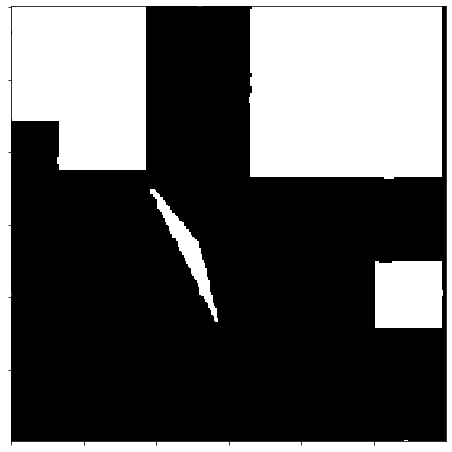

In [202]:
show_image(reducer_result.reduced_image)

## GradientBasedNoiseReducer

In [170]:
class BucketBasedSampler(object):
    def __init__(self):
        self._buckets = defaultdict(list)
        self._positions = {}

    def _remove_key(self, key):
        bucket_key, index_in_bucket  = self._positions[key]
        del self._positions[key]
        bucket = self._buckets[bucket_key]
        bucket[index_in_bucket], bucket[-1] = bucket[-1], bucket[index_in_bucket]
        bucket.pop()
        if len(bucket) > index_in_bucket:
            self._positions[bucket[index_in_bucket]] = (bucket_key, index_in_bucket)

    def set_value(self, key, value):
        if key in self._positions:
            self._remove_key(key)
        self._buckets[value].append(key)
        self._positions[key] = (value, len(self._buckets[value]) - 1)
    
    def sample_key(self):
        bucket_index_to_key = dict(enumerate(self._buckets.keys()))
        bucket_probs = np.zeros(shape=(len(self._buckets), ))
        for bucket_index, bucket_key in bucket_index_to_key.items():
            bucket_probs[bucket_index] = bucket_key * len(self._buckets[bucket_key])
        bucket_probs /= np.sum(bucket_probs)
        sampled_bucket_index = np.random.choice(len(self._buckets), p=bucket_probs)
        sampled_bucket = self._buckets[bucket_index_to_key[sampled_bucket_index]]
        key_index = np.random.randint(low=0, high=len(sampled_bucket))
        return sampled_bucket[key_index]

In [210]:
class GradientBasedNoiseReducer(SupervisedNoiseReducer):
    def __init__(
        self, noise_level_prior, observation_strength,
        coupling_strength, temperature, **kwargs
    ):
        super(GradientBasedNoiseReducer, self).__init__(**kwargs)        
        self._noise_level_prior = noise_level_prior
        self._observation_strength = observation_strength
        self._coupling_strength = coupling_strength
        if temperature < 2.0:
            raise ValueError(f"Expected temperature value >= 2.0, got {temperature}")
        self._temperature = temperature
        self.neighbours_sampler = None

    @staticmethod
    def _get_opposite_value(value):
        if value == 1.0:
            return -1.0
        elif value == -1.0:
            return 1.0
        else:
            raise ValueError(f"Invalid value: {value}")
    
    def _get_state_potential(self, observation_value, state_value):
        if observation_value == state_value:
            return self._observation_strength * np.log(1.0 - self._noise_level_prior)
        return self._observation_strength * np.log(self._noise_level_prior)

    def _update_sampler_state(self, row, column, current_state, observation_value, next_value):
        if row <= 0 or row >= current_state.shape[0] - 1:
            return
        if column <= 0 or column >= current_state.shape[1] - 1:
            return
        neighbours_sum = np.sum([
            current_state[row - 1, column], current_state[row + 1, column],
            current_state[row, column - 1], current_state[row, column + 1],
        ])
        current_value = current_state[row, column]
        values_difference = next_value - current_value
        coupling_potential = values_difference * self._coupling_strength * neighbours_sum
        next_state_potential = self._get_state_potential(observation_value, next_value)
        current_state_potential = self._get_state_potential(observation_value, current_value)
        state_potential = next_state_potential - current_state_potential
        total_potential = np.exp(self._temperature * (coupling_potential + state_potential))
        self.neighbours_sampler.set_value(key=(row, column), value=total_potential)
        
    def _preprocess(self, observation):
        self.neighbours_sampler = BucketBasedSampler()
        for row in range(observation.shape[0]):
            for column in range(observation.shape[1]):
                observation_value = observation[row, column]
                next_value = self._get_opposite_value(observation_value)
                self._update_sampler_state(
                    row, column, observation, observation_value, next_value,
                )

    def _sampler_step(self, observation, current_state):
        sampled_row, sampled_column = self.neighbours_sampler.sample_key()
        current_state[sampled_row, sampled_column] = self._get_opposite_value(
            current_state[sampled_row, sampled_column]
        )
        positions_to_update = [
            (sampled_row, sampled_column), (sampled_row - 1, sampled_column),
            (sampled_row + 1, sampled_column), (sampled_row, sampled_column - 1),
            (sampled_row, sampled_column + 1),
        ]
        for row, column in positions_to_update:
            observation_value = observation[row, column]
            next_value = self._get_opposite_value(current_state[row, column])
            self._update_sampler_state(
                row, column, current_state, observation_value, next_value,
            )

In [217]:
reducer = GradientBasedNoiseReducer(
    noise_level_prior=0.1,
    observation_strength=1.0,
    coupling_strength=1.0,    
    iterations_count=30_000,
    iterations_per_evaluation=100,
    temperature = 2.0
)
reducer_result = reducer.reduce_noise(BINARY_IMAGE_GROUND_TRUTH, BINARY_IMAGE_OBSEVATION)
reducer.average_statistics

NoiseReducerStatistics(evaluation_losses=[0.34], computation_times=[0.21001203060150148])

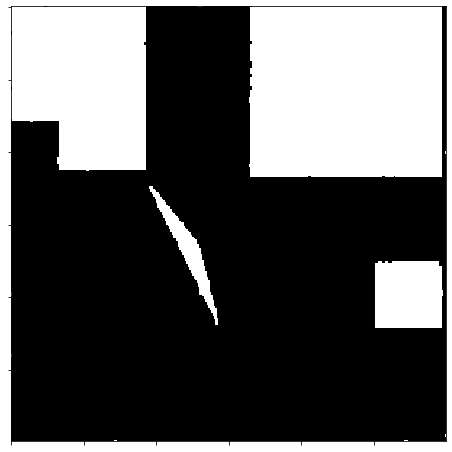

In [218]:
show_image(reducer_result.reduced_image)

## Xxx